In [1]:
import pickle
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Load the Saved files for the further consideration

In [2]:

# Load X_test
X_test_path = r'../files/X_test.pkl'

with open(X_test_path, 'rb') as file:
    X_test = pickle.load(file)

# Load X_train
X_train_path = r'../files/X_train.pkl'
with open(X_train_path, 'rb') as file:
    X_train = pickle.load(file)

# Load y_test
y_test_path = r'../files/y_test.pkl'
with open(y_test_path, 'rb') as file:
    y_test = pickle.load(file)

# Model Build

In [3]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [4]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [5]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 16s 2ms/step - loss: 0.8036 - accuracy: 0.5823 - val_loss: 0.7764 - val_accuracy: 0.6679
Epoch 2/100
  49/7108 [..............................] - ETA: 15s - loss: 0.7685 - accuracy: 0.6754

c:\Users\kpk16\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 15s 2ms/step - loss: 0.7334 - accuracy: 0.6819 - val_loss: 0.7573 - val_accuracy: 0.6900
Epoch 3/100
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7227 - accuracy: 0.6938 - val_loss: 0.7517 - val_accuracy: 0.6904
Epoch 4/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7170 - accuracy: 0.6979 - val_loss: 0.7464 - val_accuracy: 0.6999
Epoch 5/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.7122 - accuracy: 0.6979 - val_loss: 0.7426 - val_accuracy: 0.6974
Epoch 6/100
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7098 - accuracy: 0.6989 - val_loss: 0.7415 - val_accuracy: 0.6995
Epoch 7/100
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7077 - accuracy: 0.6992 - val_loss: 0.7414 - val_accuracy: 0.6973
Epoch 8/100
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7064 - accuracy: 0.6987 - val_loss: 0.7397 - val_accurac

In [6]:
autoencoder = load_model('model.h5')

# Evaluation

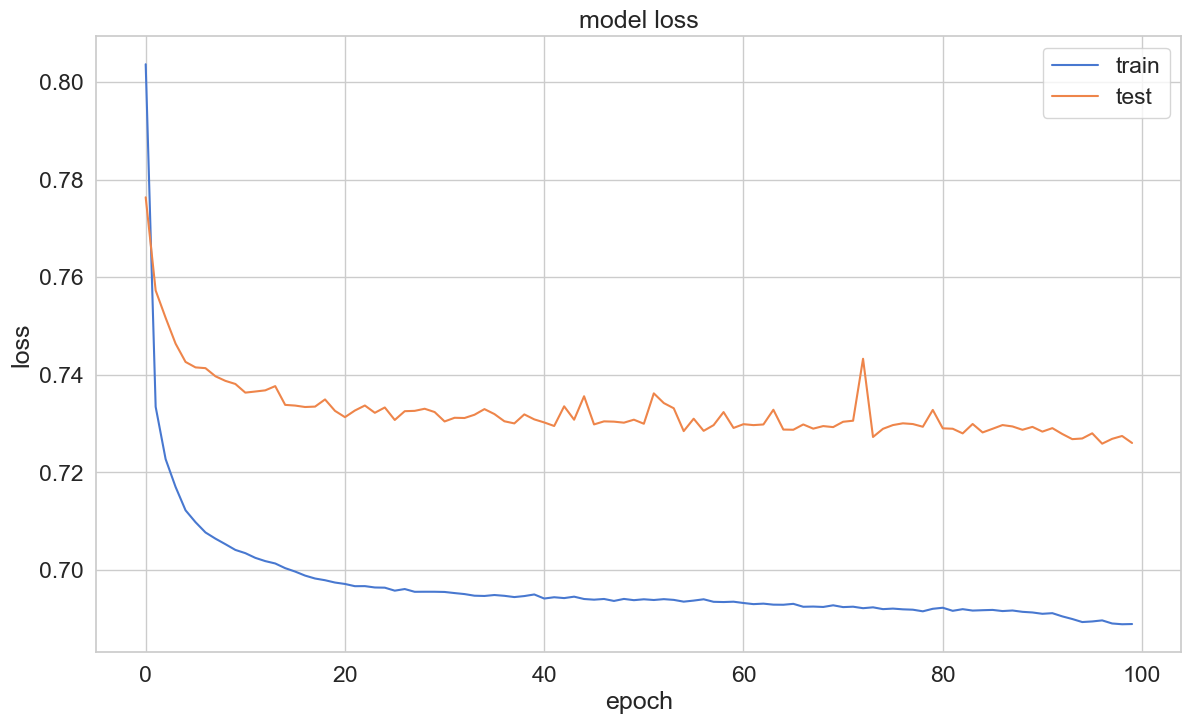

In [7]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [8]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 1s 720us/step


In [9]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [10]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.725002,0.001720
std,3.417790,0.041443
min,0.038997,0.000000
25%,0.238731,0.000000
50%,0.389762,0.000000
75%,0.613144,0.000000
max,265.713590,1.000000


# Reconstructing without Fraud

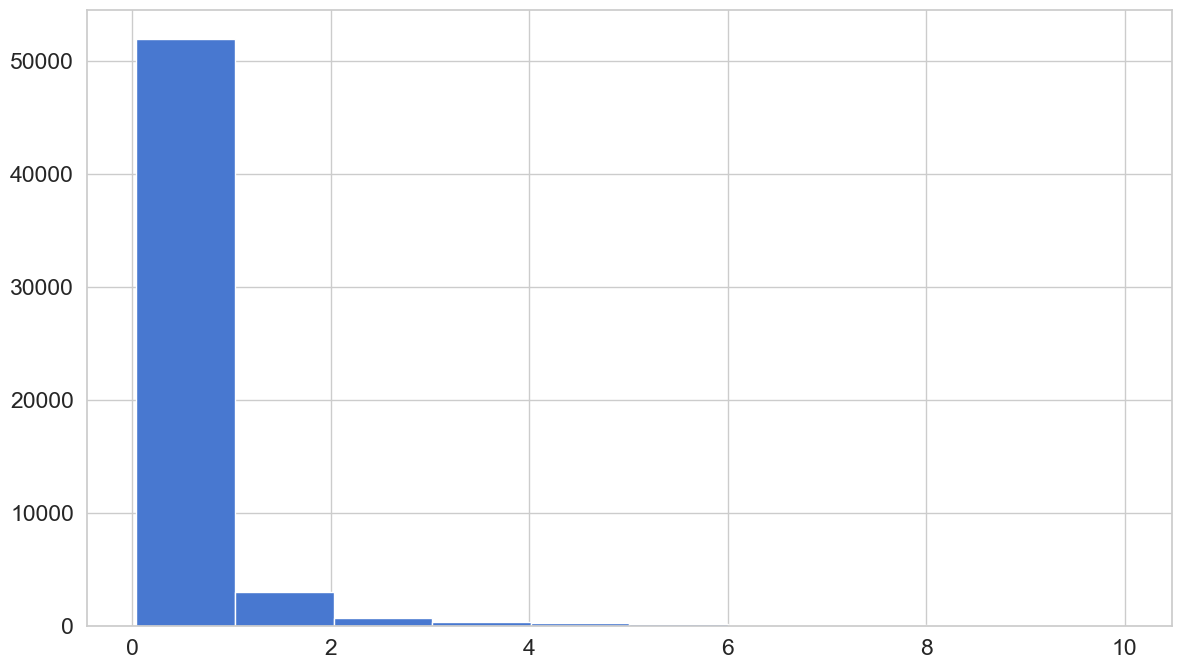

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

# Reconstruction with Fraud

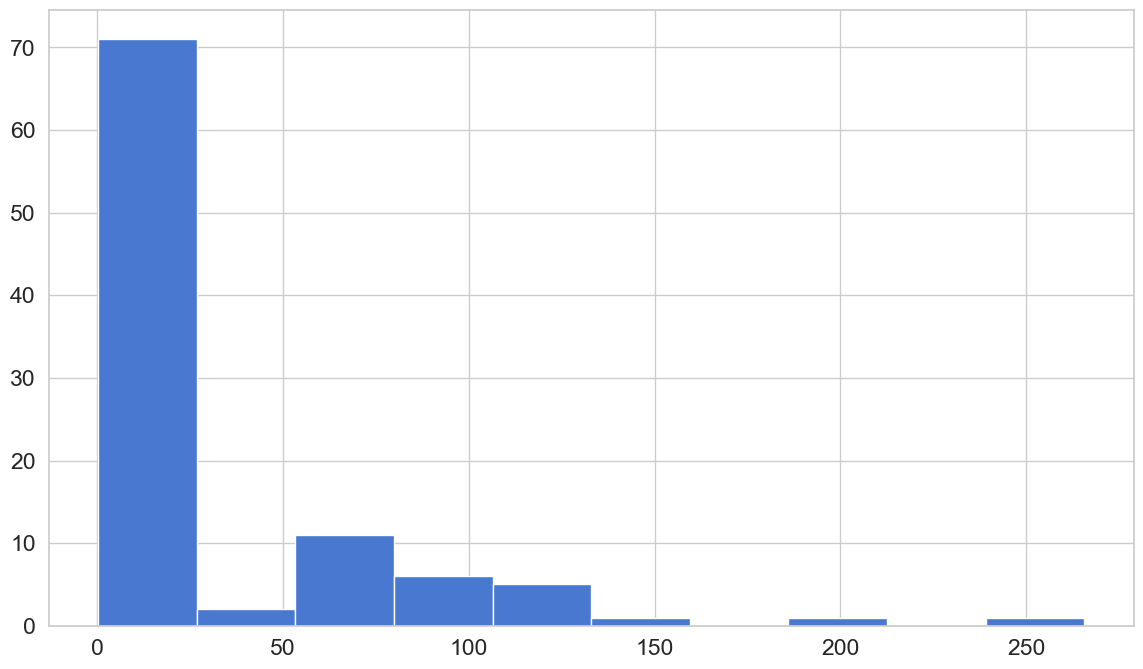

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [13]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

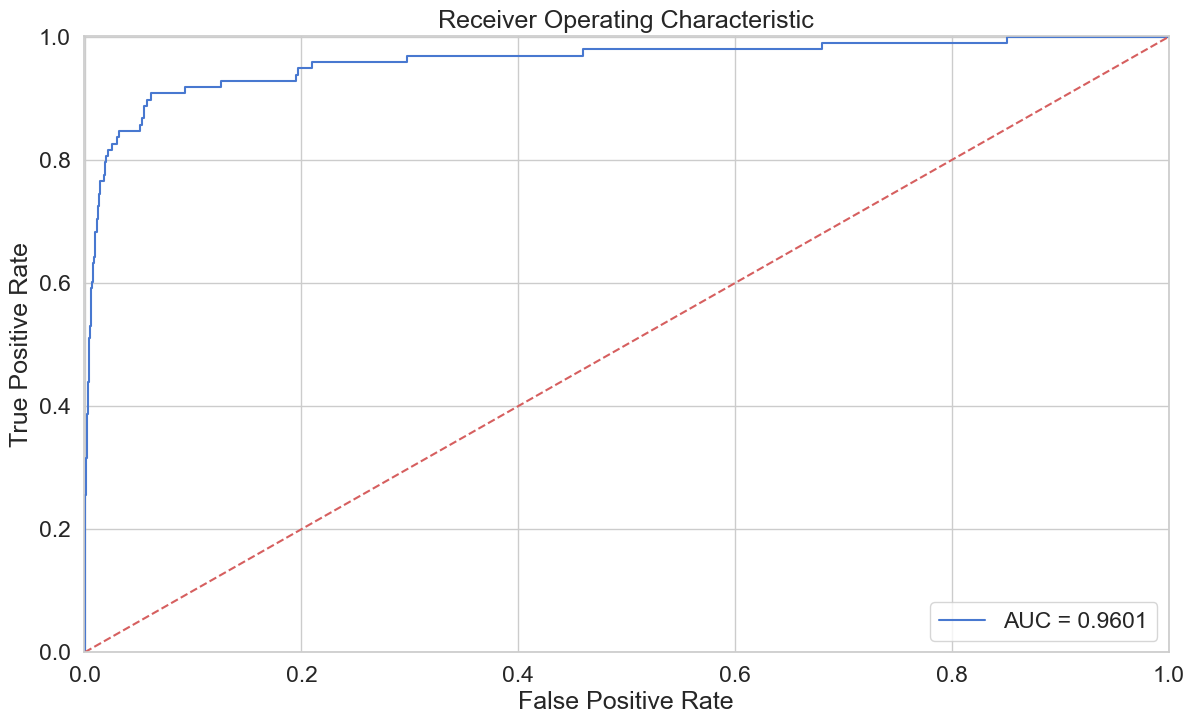

In [14]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

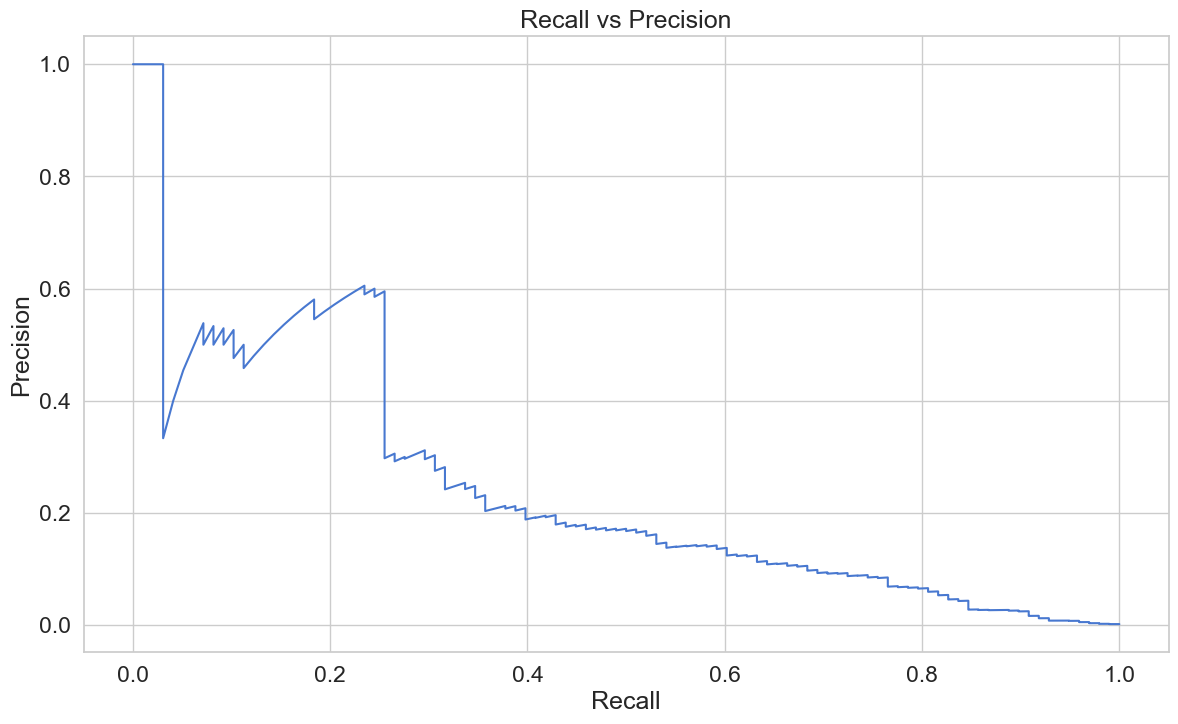

In [15]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

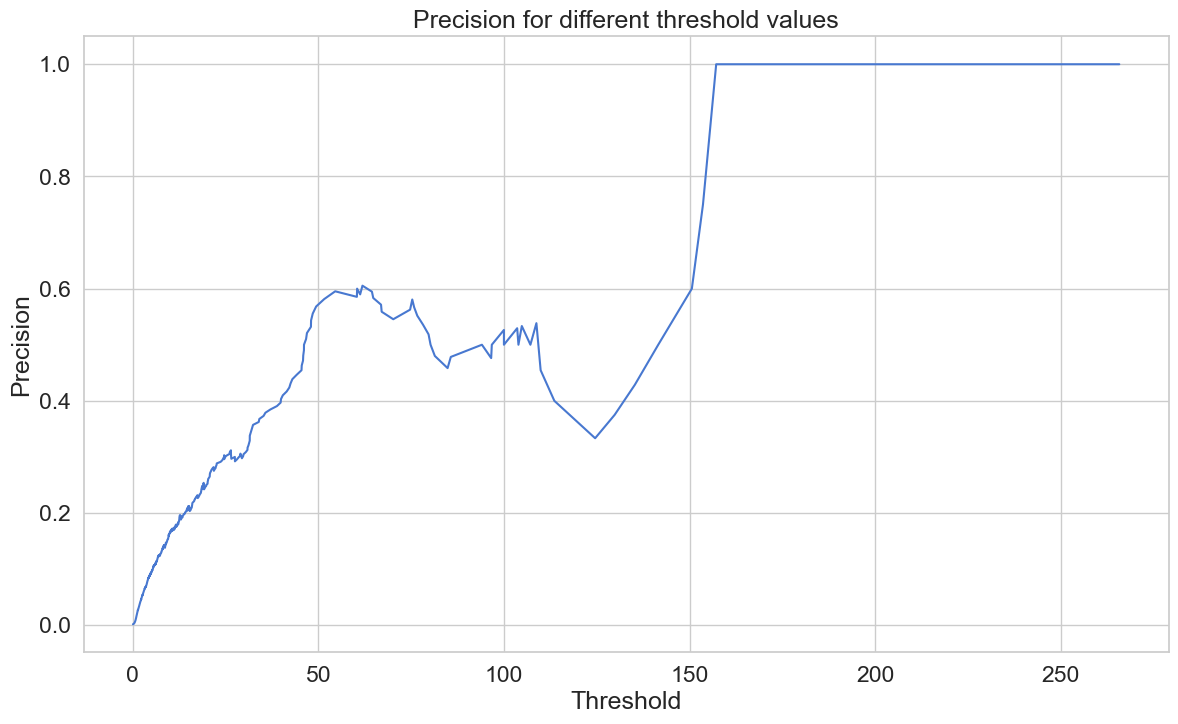

In [16]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

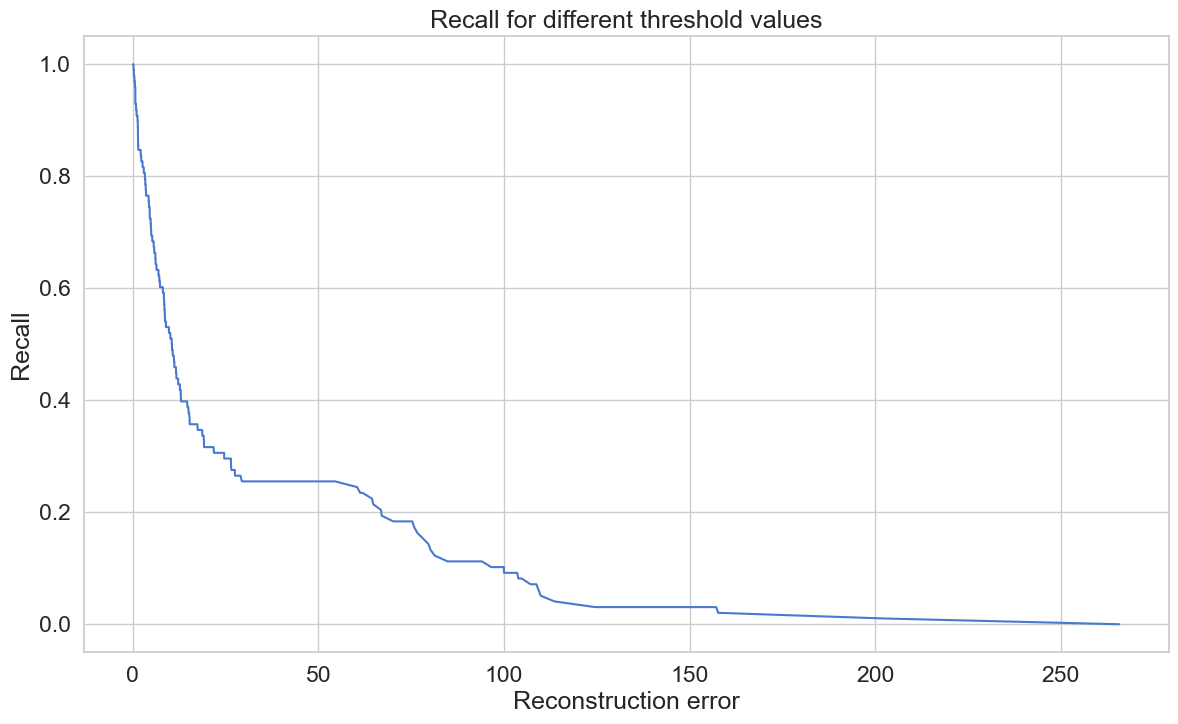

In [17]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

# Prediction

In [18]:
threshold = 1.7

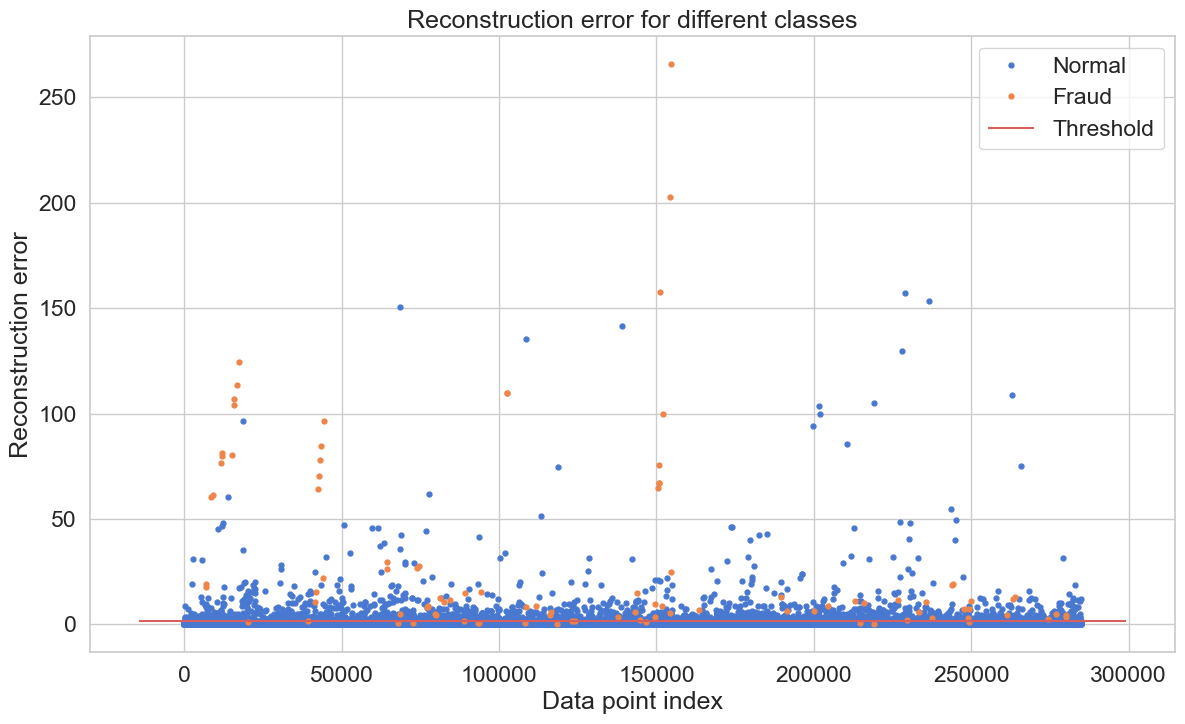

In [19]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

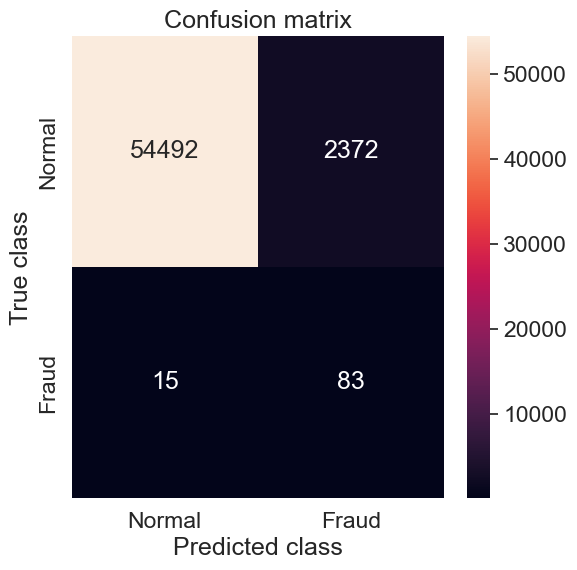

In [20]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()